In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [11]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

train.head()

Train Shape: (8693, 14)
Test Shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [12]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

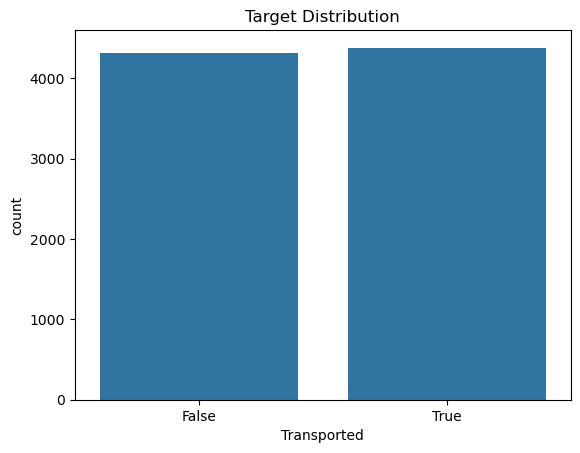

In [13]:
sns.countplot(x="Transported", data=train)
plt.title("Target Distribution")
plt.show()

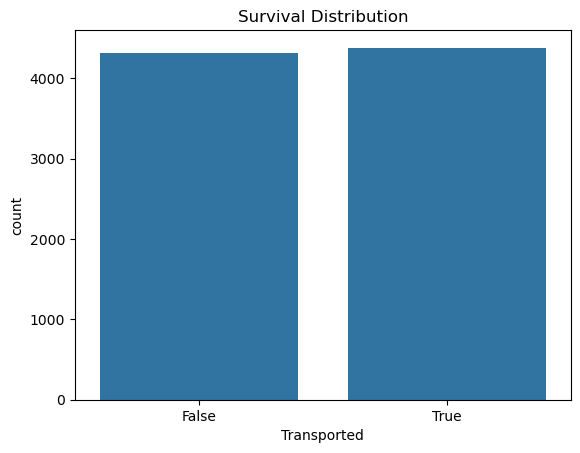

In [5]:
sns.countplot(x='Transported', data=train)
plt.title("Survival Distribution")
plt.show()

In [14]:
X = train.drop(["Transported", "PassengerId", "Name"], axis=1)
y = train["Transported"]

test_ids = test["PassengerId"]
test = test.drop(["PassengerId", "Name"], axis=1)

In [15]:
def split_cabin(df):
    df[["Deck", "CabinNum", "Side"]] = df["Cabin"].str.split("/", expand=True)
    df.drop("Cabin", axis=1, inplace=True)
    return df

X = split_cabin(X)
test = split_cabin(test)

In [16]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "bool"]).columns

In [17]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

In [18]:
model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        random_state=42
    ))
])

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [20]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'CabinNum',
       'Side'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=12, n_estimators=300,
                                        random_state=42))])

In [21]:
y_pred = model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.7492811960897068

Classification Report:

              precision    recall  f1-score   support

       False       0.71      0.83      0.77       861
        True       0.80      0.67      0.73       878

    accuracy                           0.75      1739
   macro avg       0.76      0.75      0.75      1739
weighted avg       0.76      0.75      0.75      1739



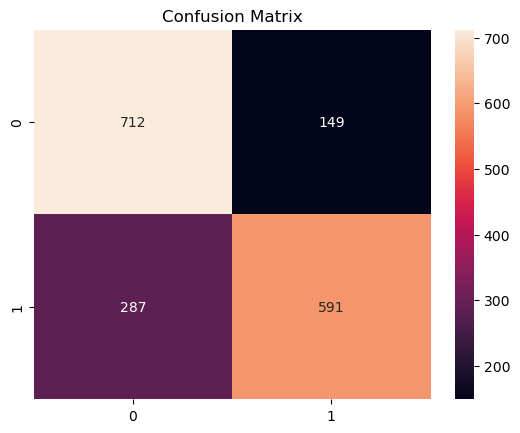

In [22]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

In [23]:
cv_scores = cross_val_score(model, X, y, cv=5)

print("Cross Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross Validation Scores: [0.73433007 0.74238068 0.7320299  0.76869965 0.76064442]
Mean CV Accuracy: 0.7476169458394073


In [24]:
model.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'CabinNum',
       'Side'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=12, n_estimators=300,
                                        random_state=42))])

In [25]:
test_predictions = model.predict(test)

In [26]:
submission = pd.DataFrame({
    "PassengerId": test_ids,
    "Transported": test_predictions
})

submission.to_csv("submission.csv", index=False)

print("Submission file created successfully!")

Submission file created successfully!
